In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
data = 'C:/Users/FurkanBulut/PycharmProjects/SolarVizyon/datasets/Detect_solar_dust'
filepaths = []
labels = []

folds = os.listdir(data)
for fold in folds:
    foldpath = os.path.join(data, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
data

filepaths labels
0     C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Clean
1     C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Clean
2     C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Clean
3     C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Clean
4     C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Clean
...                                                 ...    ...
2557  C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Dusty
2558  C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Dusty
2559  C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Dusty
2560  C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Dusty
2561  C:/Users/FurkanBulut/PycharmProjects/SolarVizy...  Dusty

[2562 rows x 2 columns]

In [6]:
# train dataframe
train_df, dummy_df = train_test_split(data,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [7]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2049 validated image filenames belonging to 2 classes.
Found 307 validated image filenames belonging to 2 classes.
Found 206 validated image filenames belonging to 2 classes.


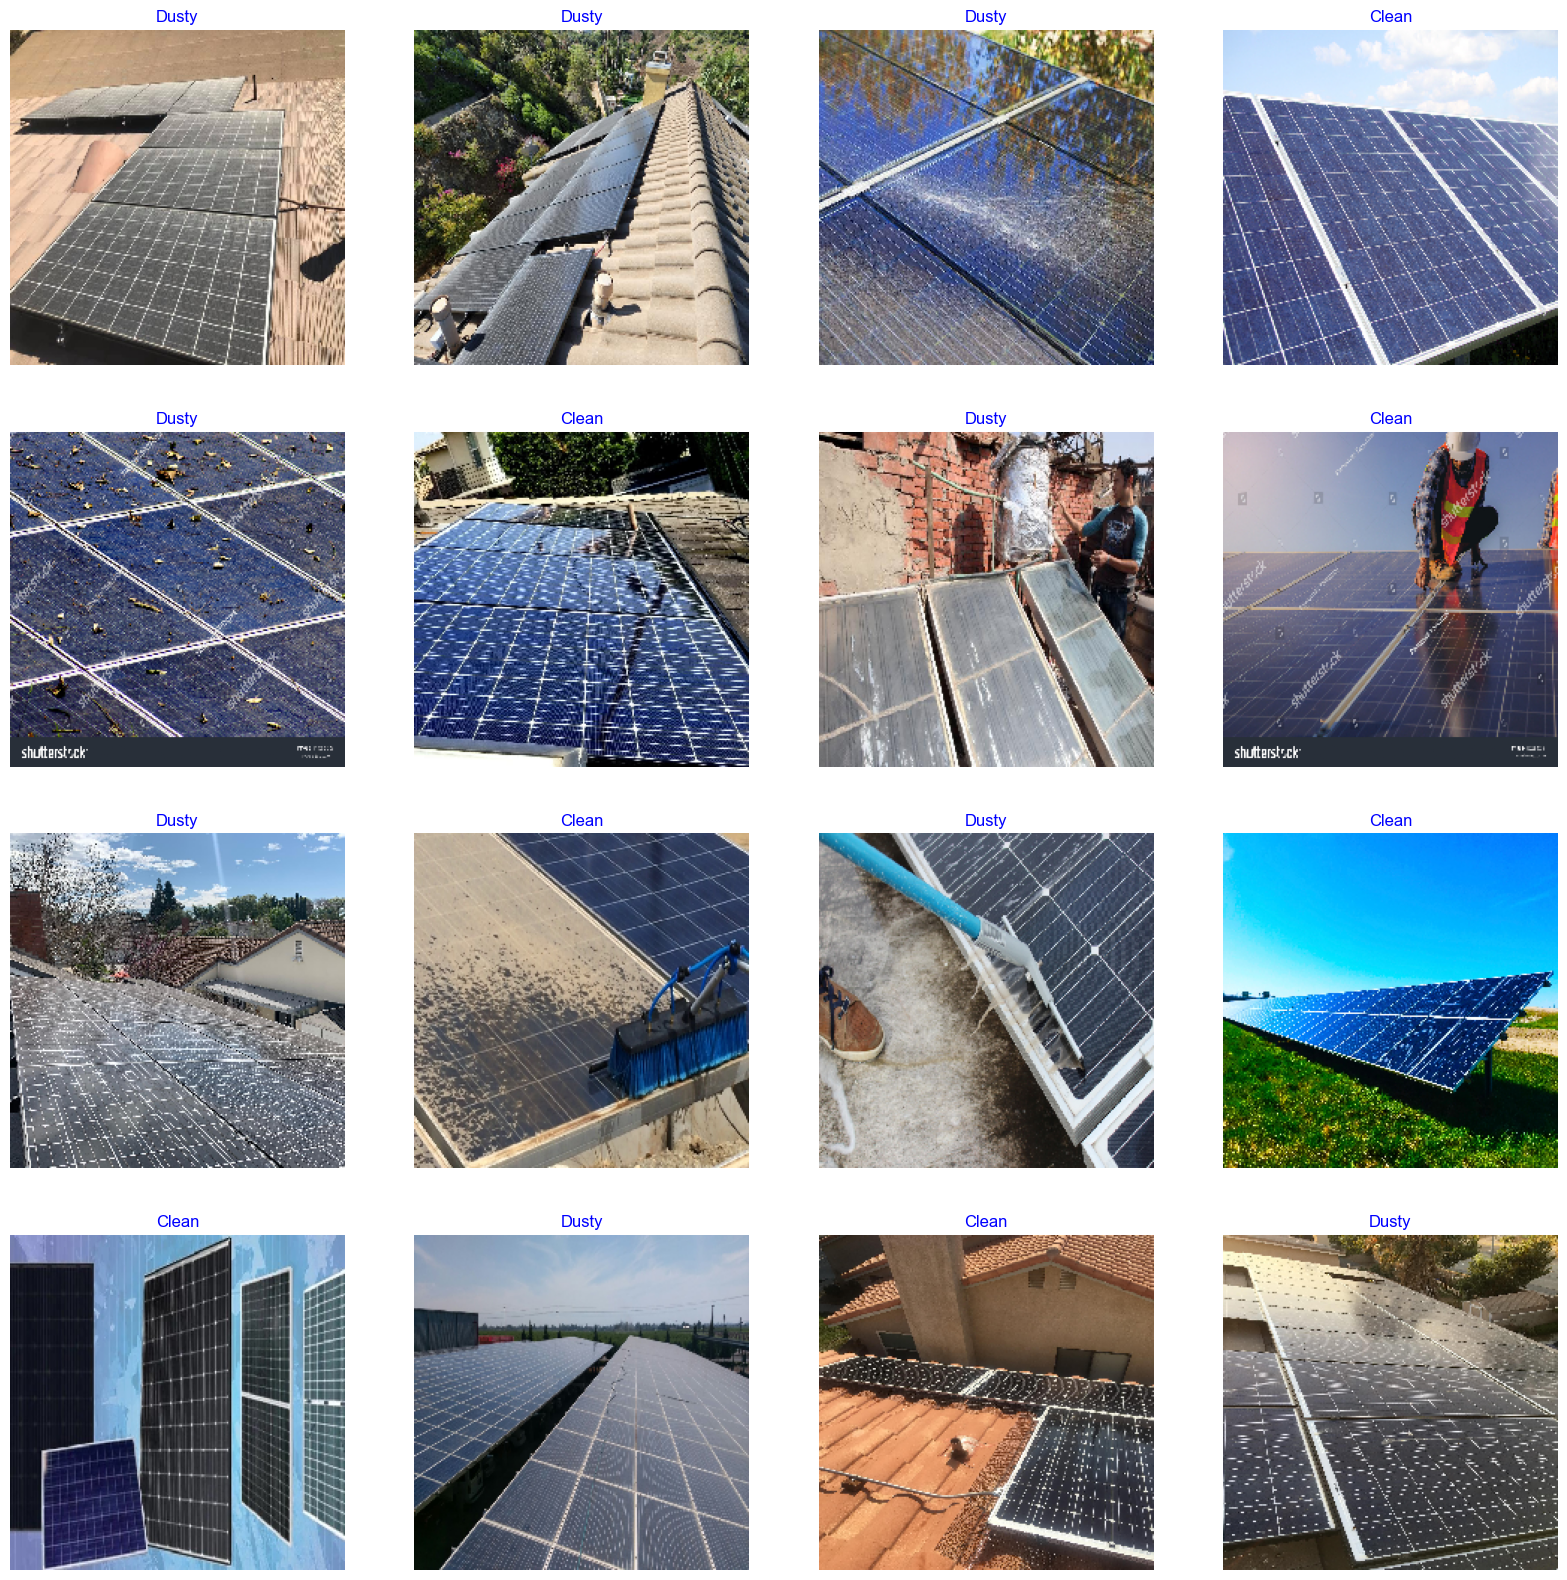

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(0.006),
      bias_regularizer=regularizers.l1(0.006), activation='relu'),

    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.5780 - loss: 13.7834 - val_accuracy: 0.6026 - val_loss: 7.0645
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5948 - loss: 5.8918 - val_accuracy: 0.6156 - val_loss: 6.0017
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5801 - loss: 4.9183 - val_accuracy: 0.6124 - val_loss: 4.6254
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5755 - loss: 4.0942 - val_accuracy: 0.6059 - val_loss: 3.8118
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5770 - loss: 3.3832 - val_accuracy: 0.6026 - val_loss: 3.3042
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5891 - loss: 2.8413 - val_accuracy: 0.5993 - val_loss: 2.7783
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5774 - loss: 2.3602 - val_accuracy: 0.6026 - val_loss: 2.2876
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5712 - loss: 1.9965 - val_acc

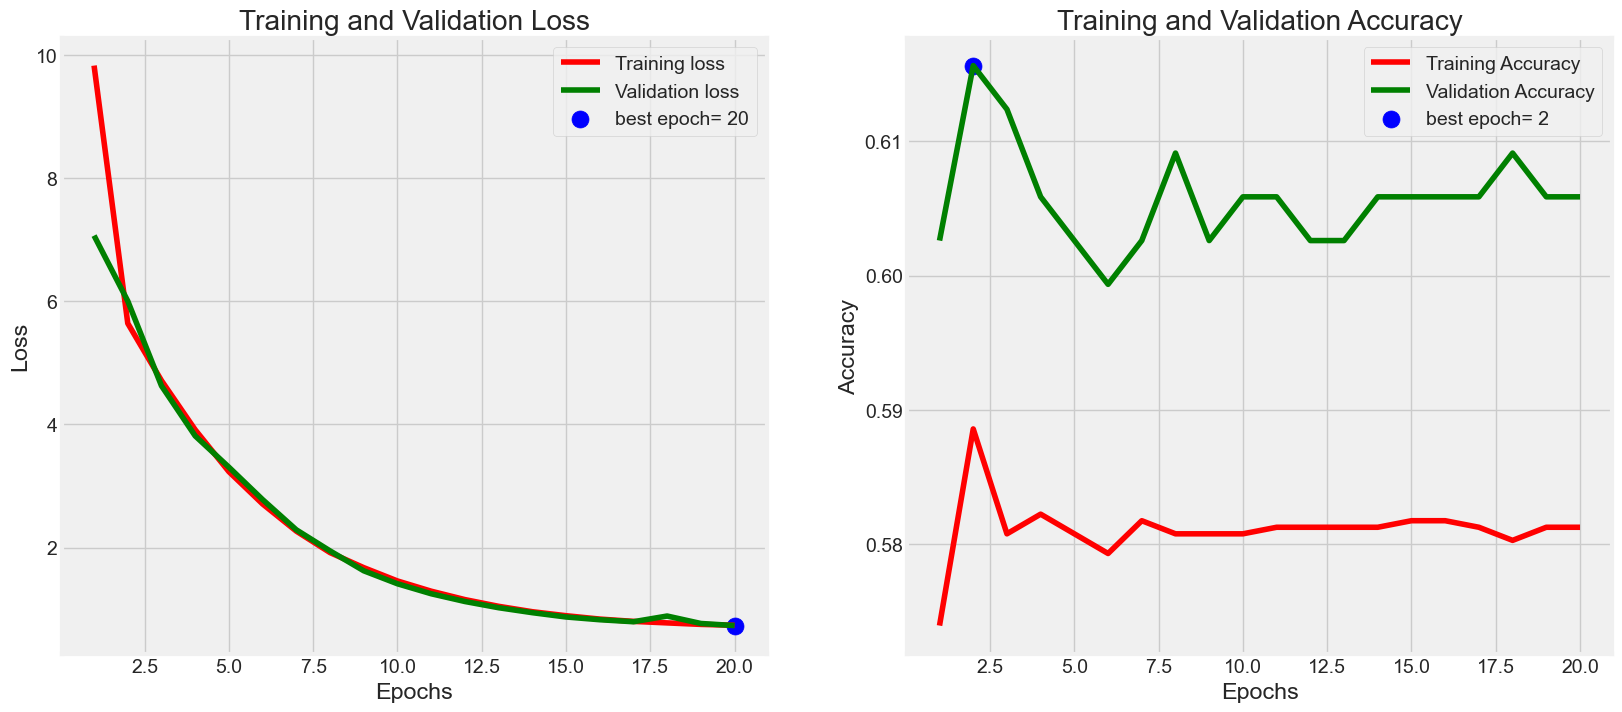

In [12]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [13]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 330ms/step - accuracy: 0.5888 - loss: 0.7399
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6009 - loss: 0.7340  
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5611 - loss: 0.7385  
Train Loss:  0.7420445680618286
Train Accuracy:  0.5813106894493103
--------------------
Validation Loss:  0.7330211997032166
Validation Accuracy:  0.6058632135391235
--------------------
Test Loss:  0.7378326654434204
Test Accuracy:  0.5631067752838135


In [17]:
# Make predictions using the model directly
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step


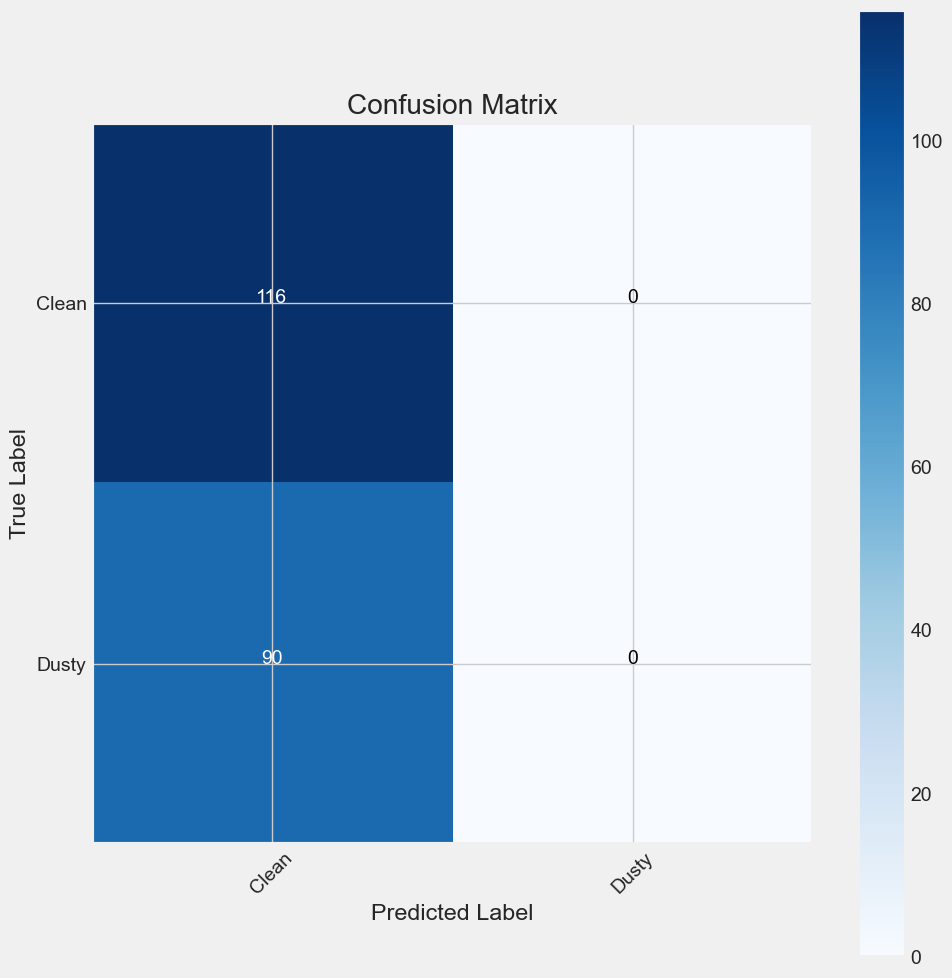

In [47]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [48]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Clean       0.56      1.00      0.72       116
       Dusty       0.00      0.00      0.00        90

    accuracy                           0.56       206
   macro avg       0.28      0.50      0.36       206
weighted avg       0.32      0.56      0.41       206


In [67]:
#Save the model
model.save('efficientnet.keras')


In [70]:
loaded_model = tf.keras.models.load_model('efficientnet.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
loaded_model.save('efficientnet.keras')

ValueError: Input 0 of layer "dense_1" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (256,)

In [66]:
image_path = 'C:/Users/FurkanBulut/PycharmProjects/SolarVizyon/datasets/Detect_solar_dust/Dusty/Imgdirty_77_1.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

NameError: name 'loaded_model' is not defined

In [64]:
image_path = 'C:/Users/FurkanBulut/PycharmProjects/SolarVizyon/datasets/Detect_solar_dust/Dusty/Imgdirty_77_1.jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Clean


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


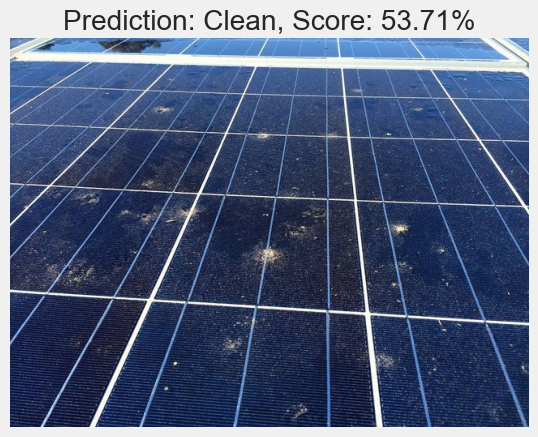

In [65]:
import matplotlib.pyplot as plt

# Model tahminlerini al
predictions = model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
predicted_class = class_labels[tf.argmax(score)]

# Görüntüyü göster
plt.imshow(image)
plt.title(f"Prediction: {predicted_class}, Score: {100 * tf.reduce_max(score):.2f}%")
plt.axis('off')
plt.show()
